In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

2024-04-28 10:54:44.990919: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-28 10:54:44.991056: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-28 10:54:45.098922: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2, rotation_range=5,
                                   width_shift_range=0.2,height_shift_range=0.2,
                                   shear_range=0.2, #zoom_range=0.2, 
                                   horizontal_flip=True,vertical_flip=True,
                                   fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)
test_datagen  = ImageDataGenerator(rescale = 1./255)

In [3]:
train  = train_datagen.flow_from_directory(directory = '/kaggle/input/fer2013/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 22968 images belonging to 7 classes.


In [4]:
valid = valid_datagen.flow_from_directory(directory = '/kaggle/input/fer2013/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 5741 images belonging to 7 classes.


In [5]:
test = test_datagen.flow_from_directory(directory = '/kaggle/input/fer2013/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 7178 images belonging to 7 classes.


In [6]:
ResNet =ResNet50V2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
for layer in ResNet.layers[:-50]:
    layer.trainable = False

In [8]:
ResNet.output

<KerasTensor shape=(None, 7, 7, 2048), dtype=float32, sparse=False, name=keras_tensor_189>

In [9]:
x = Flatten()(ResNet.output)

# Adding a fully connected layer with ReLU activation and He normal initializer
x = Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization

x = Dense(512, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization

output = Dense(7, activation='softmax', kernel_initializer='he_normal')(x)
res = Model(inputs=ResNet.input, outputs=output)

In [10]:
res.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 126,854,663 (483.91 MB)

 Trainable params: 119,642,119 (456.40 MB)

 Non-trainable params: 7,212,544 (27.51 MB)

In [11]:
# Metrics=[
#       tf.keras.metrics.BinaryAccuracy(name='accuracy'), 
#       tf.keras.metrics.AUC(name='auc')
# ]

In [12]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)
es = EarlyStopping(verbose=1, patience=20)

In [13]:
res.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [14]:
history=res.fit(train,
                  validation_data=valid,
                  epochs = 25,
                  verbose = 1,
                  callbacks=[lrd,es]
                 )

Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1714301778.966648     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714301779.026898     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


104/359 ━━━━━━━━━━━━━━━━━━━━ 3:53 915ms/step - accuracy: 0.1988 - loss: 4.0398

W0000 00:00:1714301905.623870     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2710 - loss: 2.6461

W0000 00:00:1714302143.091798     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


359/359 ━━━━━━━━━━━━━━━━━━━━ 461s 1s/step - accuracy: 0.2712 - loss: 2.6440 - val_accuracy: 0.4151 - val_loss: 1.4329 - learning_rate: 0.0010
Epoch 2/25


W0000 00:00:1714302186.996840     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


359/359 ━━━━━━━━━━━━━━━━━━━━ 289s 791ms/step - accuracy: 0.4373 - loss: 1.4516 - val_accuracy: 0.4792 - val_loss: 4.2236 - learning_rate: 0.0010
Epoch 3/25
359/359 ━━━━━━━━━━━━━━━━━━━━ 275s 751ms/step - accuracy: 0.4718 - loss: 1.4078 - val_accuracy: 0.3597 - val_loss: 1.9591 - learning_rate: 0.0010
Epoch 4/25
359/359 ━━━━━━━━━━━━━━━━━━━━ 277s 756ms/step - accuracy: 0.5122 - loss: 1.3321 - val_accuracy: 0.5398 - val_loss: 1.2345 - learning_rate: 0.0010
Epoch 5/25
359/359 ━━━━━━━━━━━━━━━━━━━━ 273s 746ms/step - accuracy: 0.5452 - loss: 1.2444 - val_accuracy: 0.5497 - val_loss: 1.1989 - learning_rate: 0.0010
Epoch 6/25
359/359 ━━━━━━━━━━━━━━━━━━━━ 280s 764ms/step - accuracy: 0.5526 - loss: 1.2083 - val_accuracy: 0.5187 - val_loss: 1.5353 - learning_rate: 0.0010
Epoch 7/25
359/359 ━━━━━━━━━━━━━━━━━━━━ 275s 752ms/step - accuracy: 0.5763 - loss: 1.1578 - val_accuracy: 0.3762 - val_loss: 2.5946 - learning_rate: 0.0010
Epoch 8/25
359/359 ━━━━━━━━━━━━━━━━━━━━ 274s 749ms/step - accuracy: 0.5795 

In [15]:
def Plots(history):
    """
    Plots the training and validation accuracy and loss.

    Parameters:
    - history: A Keras History object. Contains the logs from the training process.

    Returns:
    - None. Displays the matplotlib plots for training/validation accuracy and loss.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

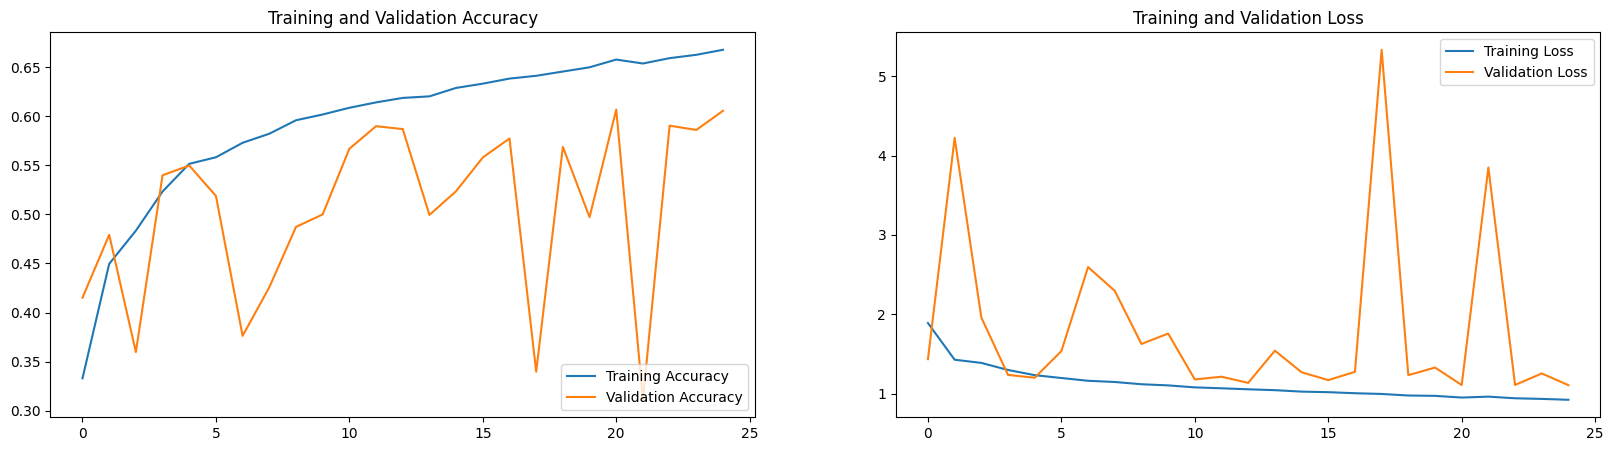

In [16]:
Plots(history)

In [17]:
t_loss, t_accu = res.evaluate(test)
print("Test accuracy = {:.2f}".format(t_accu*100))

113/113 ━━━━━━━━━━━━━━━━━━━━ 53s 467ms/step - accuracy: 0.6047 - loss: 1.0857
Test accuracy = 60.48


W0000 00:00:1714308931.129539     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


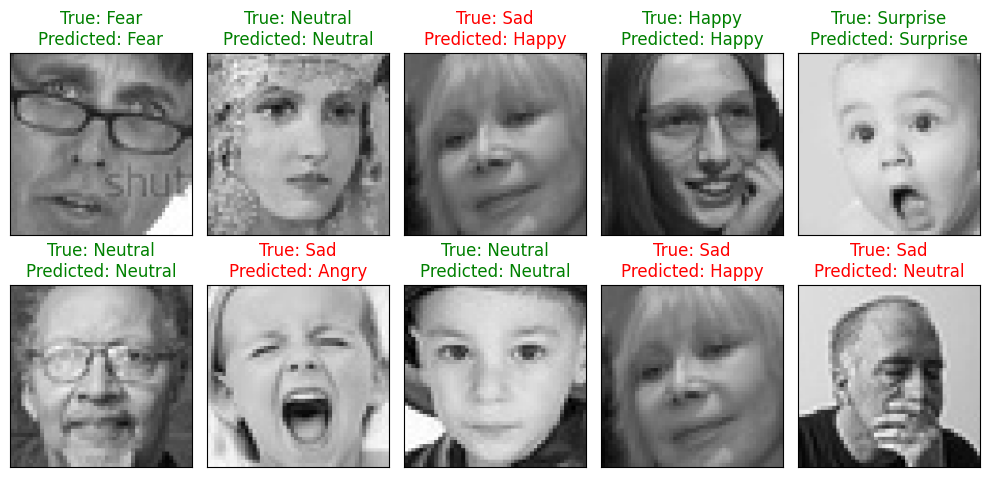

In [18]:
# Emotion classes for the dataset
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Assuming test_generator and model are already defined
batch_size = test.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(res.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

In [19]:
res.save('ResNet.h.keras')